In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
from skimage.feature import hog
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from scipy.ndimage.measurements import label
import csv
import random as rand
%matplotlib inline

aug_folder_path = "/sumsung2T/udacity/vehical_tracking/object-dataset/"
vehical_image = "/sumsung2T/udacity/vehical_tracking/vehicles/"
non_vehical_images = "/sumsung2T/udacity/vehical_tracking/non-vehicles/"


In [2]:
# function to draw images (Taken from some randow github page)
def show_images_in_table (images, table_size, fig_size = (10, 10), cmap=None, titles=None):
    """Shows images in table
    Args:
        images (list): list of input images
        table_size (tuple): (cols count, rows count)
        fig_size (tuple): picture (size x, size y) in inches
        cmap (list): list of cmap parameters for each image
        titles (list): list of images titles
    """
    sizex = table_size [0]
    sizey = table_size [1]
    fig, imtable = plt.subplots (sizey, sizex, figsize = fig_size, squeeze=False)
    for j in range (sizey):
        for i in range (sizex):
            im_idx = i + j*sizex
            if (isinstance(cmap, (list, tuple))):
                imtable [j][i].imshow (images[im_idx], cmap=cmap[i])
            else:
                im = images[im_idx]
                if len(im.shape) == 3:
                    imtable [j][i].imshow (im)
                else:
                    imtable [j][i].imshow (im, cmap='gray')
            imtable [j][i].axis('off')
            if not titles is None:
                imtable [j][i].set_title (titles [im_idx], fontsize=32)

    plt.show ()

def plt_show_gray (image):
    """Shows gray image
    Args:
        image: image to show
    """
    plt.figure ()
    plt.imshow (image, cmap='gray')
    plt.show ()

def plt_show (image):
    """Shows color image in RGB format
    Args:
        image: image to show
    """
    plt.figure ()
    plt.imshow (image)
    plt.show ()

In [3]:
#function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    
    hist_features = []    
    if COLOR_SPEC == 'GRAY':
        hist_features.extend(np.histogram(img, bins=nbins, range=bins_range)[0])
    else:
        for channel in range(img.shape[2]):
            hist_features.extend(np.histogram(img[:,:,channel], bins=nbins, range=bins_range)[0])
    return hist_features
    


In [4]:
# function to change the size of an image and unravel it
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    
    return features

In [5]:
# function to change the color spec of the image and return the new image 
def change_color_spec(img, color_space='RGB'):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'GRAY':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else: 
        feature_image = np.copy(img) 
    return feature_image

In [6]:
# function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm="L2-Hys")
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm="L2-Hys")
        return features

In [7]:
# fuction to calculate features on a given image
def single_image_feature(img):
    
    single_features = []
    colored_img = change_color_spec(img, color_space=COLOR_SPEC)
    if SPATIAL_FEATURES == True:
        bin_spatial_features = bin_spatial(colored_img, size=SIZE)
        single_features.extend(bin_spatial_features)
    if HIST_FEATURES == True:
        color_hist_features = color_hist(colored_img, nbins=NBINS, bins_range=(0, 256))
        single_features.extend(color_hist_features)
    if HOG_FEATURES == True:
        hog_features = []
        if COLOR_SPEC == 'GRAY':
            hog_features.extend(get_hog_features(colored_img, orient=ORIENT, pix_per_cell=PIX_PER_CELL,
                                   cell_per_block=CELL_PER_BLOCK, vis=False, feature_vec=True))
            
        elif HOG_CHANNEL == 'ALL':
            
            for channel in range(colored_img.shape[2]):
                hog_features.extend(get_hog_features(colored_img[:,:,channel], orient=ORIENT, pix_per_cell=PIX_PER_CELL,
                                   cell_per_block=CELL_PER_BLOCK, vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(colored_img[:,:,HOG_CHANNEL], orient=ORIENT, pix_per_cell=PIX_PER_CELL,
                                   cell_per_block=CELL_PER_BLOCK, vis=False, feature_vec=True)
        
        single_features.extend(hog_features)
    
    
    return np.array(single_features)
    
    

In [8]:
# fuctin to create the feature space on given image list
def extract_features(img_list):
    feature_list = []
    for img in img_list:
        # read the image
        #img = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB), (64,64))
        single_feature = single_image_feature(img) 
        
        feature_list.append(single_feature)       
    return(feature_list)
        

    

In [9]:
# function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img =car_list[0]
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict

In [10]:
# function of read csv file from autti data set to augment the data

def read_label_csv(csv_file_path = aug_folder_path + "labels.csv"):
    autti_images = {}
    car_count = 0
    with open(csv_file_path, 'r') as f:
        reader = csv.reader(f, delimiter='\t')
        for i, line in enumerate(reader):
            row = line[0].split()
            imgname = row[0]
            if imgname not in autti_images:
                image_data = {
                    'imgpath' : aug_folder_path  + imgname,
                    'car_boxes' : []
                }
                autti_images[imgname] = image_data

            if(row[6] == '"car"' ):
                car_box = {
                    'xmin' : int(row [1]),
                    'ymin' : int(row [2]),
                    'xmax' : int(row [3]),
                    'ymax' : int(row [4])
                }
                autti_images[imgname]['car_boxes'].append(car_box)
                car_count += 1

    print ('autti images:', len (autti_images))
    print ('cars:', car_count)
    
    return(autti_images)

In [11]:
# check if one box is intersected with given list of boxes (taken from internet)

def is_intersect (box, boxes):
    
    x1, x2, y1, y2 = box ['xmin'], box ['xmax'], box ['ymin'], box ['ymax']
    for b in boxes:
        bx1, bx2, by1, by2 = b ['xmin'], b ['xmax'], b ['ymin'], b ['ymax']
        if (
            (
                (
                    (x1 >= bx1 and x1 <= bx2) or 
                    (x2 >= bx1 and x2 <= bx2)
                ) and
                (
                    (y1 >= by1 and y1 <= by2) or 
                    (y2 >= by1 and y2 <= by2)
                )
            ) or
            (
                (
                    (bx1 >= x1 and bx1 <= x2) or 
                    (bx2 >= x1 and bx2 <= x2)
                ) and
                (
                    (by1 >= y1 and by1 <= y2) or 
                    (by2 >= y1 and by2 <= y2)
                )
            )
        ):
            return True
        
    return False


In [12]:
# list to store the actual pixel values of images

# code to read the data from local folder
cars_imgs = []
notcars_imgs = []
aug_cars_imgs = []
aug_notcars_imgs = []

for subpath, subdirs, img_files in os.walk(vehical_image):
    for name in img_files:
        if name.endswith(".png"):
            cars_imgs.append(cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(subpath, name)), cv2.COLOR_BGR2RGB), (64,64)))
            
            
for subpath, subdirs, img_files in os.walk(non_vehical_images):
    for name in img_files:
        if name.endswith(".png"):
            notcars_imgs.append(cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(subpath, name)), cv2.COLOR_BGR2RGB), (64,64)))
    
data_info = data_look(cars_imgs, notcars_imgs)

print("Before Augmentation")
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


Before Augmentation
Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


In [13]:
l = [cars_imgs[rand.randint (0, len(cars_imgs)-1)],
     cars_imgs[rand.randint (0, len(cars_imgs)-1)],
     cars_imgs[rand.randint (0, len(cars_imgs)-1)],
     cars_imgs[rand.randint (0, len(cars_imgs)-1)],
     cars_imgs[rand.randint (0, len(cars_imgs)-1)],
     
     notcars_imgs[rand.randint (0, len(notcars_imgs)-1)],
     notcars_imgs[rand.randint (0, len(notcars_imgs)-1)],
     notcars_imgs[rand.randint (0, len(notcars_imgs)-1)],
     notcars_imgs[rand.randint (0, len(notcars_imgs)-1)],
     notcars_imgs[rand.randint (0, len(notcars_imgs)-1)]
    ]
     
     

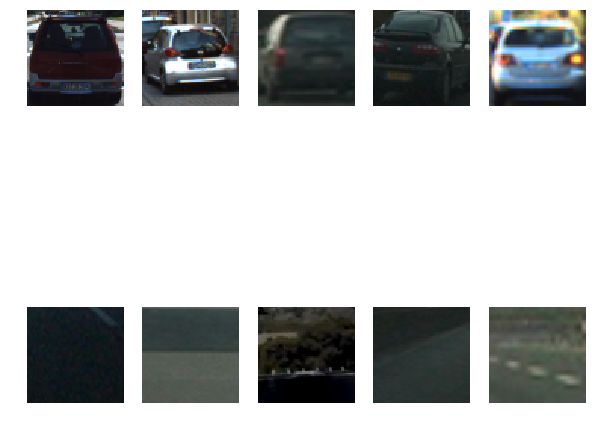

In [14]:
show_images_in_table(l,table_size=(5,2))

In [ ]:
### code to read data from autti data set and augment original data ##

autti_images = read_label_csv()


num_cars = 0
num_not_cars = 0

while num_cars < 20000 or num_not_cars < 20000:
    
    
    
    index = rand.randint(0, len(autti_images)-1)
    img_name = list(autti_images.keys())[index]
    img = cv2.cvtColor(cv2.imread(autti_images[img_name]['imgpath']), cv2.COLOR_BGR2RGB)   
    
    if num_cars < 20000:
        
        for cars in autti_images[img_name]['car_boxes']:
            car = img[cars['ymin']:cars['ymax'], cars['xmin']:cars['xmax']]
            #cv2.imwrite(vehicle_data_path + "{}.png".format(no_cars),cv2.resize(car, (64,64)))
            aug_cars_imgs.append(cv2.resize(car, (64,64)))
            num_cars += 1
            if num_cars % 500 == 0:
                print("car: ", num_cars)


        
        
    if num_not_cars < 20000:
        
        not_car_boxes = []
        for i in range(5):
            pos = [rand.randint (0, img.shape[1]-65),rand.randint (0, img.shape[0] - 65)]
            not_car = {
                    'xmin': pos [0],
                    'ymin': pos [1],
                    'xmax': pos [0] + 64,
                    'ymax': pos [1] + 64
                }
            not_car_boxes.append(not_car)

        for not_car_box in not_car_boxes:
            
            if not is_intersect (not_car_box, autti_images[img_name]['car_boxes']):
                not_car = img[not_car_box['ymin']:not_car_box['ymax'], not_car_box['xmin']:not_car_box['xmax']]
                #cv2.imwrite(non_vehicle_data_path + "{}.png".format(no_not_cars),cv2.resize(not_car, (64,64)))
                aug_notcars_imgs.append(cv2.resize(not_car, (64,64)))
                num_not_cars += 1
                if num_not_cars % 500 == 0:
                    print("not cars: ", num_not_cars)

data_info = data_look(aug_cars_imgs, aug_notcars_imgs)
print("\n\n\n")
print("augmented results")
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
print("\n\n\n")



print("adding both original and augmented")
cars_imgs.extend(aug_cars_imgs)
notcars_imgs.extend(aug_notcars_imgs)

data_info = data_look(cars_imgs, notcars_imgs)
print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])


In [ ]:
l = [aug_cars_imgs[rand.randint(0, len(aug_cars_imgs)-1)],
     aug_cars_imgs[rand.randint(0, len(aug_cars_imgs)-1)],
     aug_cars_imgs[rand.randint(0, len(aug_cars_imgs)-1)],
     aug_cars_imgs[rand.randint(0, len(aug_cars_imgs)-1)],
     aug_cars_imgs[rand.randint(0, len(aug_cars_imgs)-1)],
     
     aug_notcars_imgs[rand.randint(0, len(aug_notcars_imgs)-1)],
     aug_notcars_imgs[rand.randint(0, len(aug_notcars_imgs)-1)],
     aug_notcars_imgs[rand.randint(0, len(aug_notcars_imgs)-1)],
     aug_notcars_imgs[rand.randint(0, len(aug_notcars_imgs)-1)],
     aug_notcars_imgs[rand.randint(0, len(aug_notcars_imgs)-1)],
     
    ]

In [ ]:
show_images_in_table(l, (5,2))

In [15]:
# different paramter combination can be explored here

COLOR_SPEC='YUV'
SIZE=(16,16)
NBINS=16
ORIENT=11
PIX_PER_CELL=16
CELL_PER_BLOCK=2
HOG_CHANNEL = 'ALL'
SPATIAL_FEATURES = False
HIST_FEATURES = False
HOG_FEATURES = True

car_features = extract_features(cars_imgs)
not_car_features = extract_features(notcars_imgs)

features = np.vstack((car_features,not_car_features))
 
    
labels = np.hstack((np.ones(len(car_features)), np.zeros(len(not_car_features)))) 
    

In [16]:
features.shape

(17760, 1188)

In [17]:
# normalizing the feature space

eatures, labels = shuffle(features, labels, random_state=1234)
features_scaler = StandardScaler().fit(features)
scaled_features = features_scaler.transform(features)

In [18]:
# dividing the data in training and testing
features_train, features_test, labels_train, labels_test = train_test_split(scaled_features, labels, test_size=0.2, random_state=1234)

In [19]:
# fitting a SVM classifier
svc = SVC()
svc.fit(features_train, labels_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
# getting the testing accuracy
svc.score(features_test, labels_test)

0.987331081081081

In [21]:
# classifier is build we need to do inference now

In [22]:
# function to draw boxes in an image

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



In [23]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [24]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


In [25]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [26]:
def search_windows(img, windows, features_scaler, svc):   
    
    
    on_windows = []
    for window in windows:
        window_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #print(window_test_img.shape)
        window_img_features = single_image_feature(window_img)
        #print(window_test_img_features.shape)
        #print(window_test_img_features)
        window_img_features_norm = features_scaler.transform(window_img_features.reshape(1, -1))
        #print(window_test_img_features_norm)
        prediction = svc.predict(window_img_features_norm)
        if prediction == 1:
            on_windows.append(window)

    return on_windows

In [118]:
#for each test image
vidcap = cv2.VideoCapture("../CarND-Vehicle-Detection/project_video.mp4")
success,test_image = vidcap.read()
print(success)
i = 0
while success:
    success,test_image = vidcap.read()
    if success == False:
        print("Read all the frames...exiting")
        continue
        
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    
    #test_image_path = "../CarND-Vehicle-Detection/test_images/test6.jpg"
    #test_image = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)
    
    windows_1 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[400, 484],xy_window=(64, 64), xy_overlap=(0.50, 0.750))
    windows_2 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[416, 484],xy_window=(64, 64), xy_overlap=(0.50, 0.750))
    windows_3 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[400, 528],xy_window=(96, 96), xy_overlap=(0.50, 0.750))
    windows_4 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[432, 528],xy_window=(96, 96), xy_overlap=(0.50, 0.750))
    windows_5 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[400, 550],xy_window=(128, 128), xy_overlap=(0.50, 0.750))
    windows_6 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[432, 560],xy_window=(128, 128), xy_overlap=(0.50, 0.750))
    windows_7 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[400, 656],xy_window=(192, 192), xy_overlap=(0.50, 0.750))
    windows_8 = slide_window(test_image, x_start_stop=[0, 1280], y_start_stop=[464, 656], xy_window=(192, 192), xy_overlap=(0.50, 0.75))


    windows = []
    windows.extend(windows_1)
    #windows.extend(windows_2)
    windows.extend(windows_3)
    #windows.extend(windows_4)
    windows.extend(windows_5)
    #windows.extend(windows_6)
    windows.extend(windows_7)
    #windows.extend(windows_8)
    
    
    on_windows = search_windows(test_image, windows, features_scaler, svc)
    xx = draw_boxes(test_image, on_windows)
    cv2.imwrite("../CarND-Vehicle-Detection/final_images/{}_box.jpg".format(i), cv2.cvtColor(xx, cv2.COLOR_RGB2BGR))
    
        
    heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
    heat_1 = add_heat(heat,on_windows)
    
    heat_2 = apply_threshold(heat_1,1)
    
    heatmap = np.clip(heat_2, 0, 255)
    labels1 = label(heatmap)
    
    draw_img = draw_labeled_bboxes(np.copy(test_image), labels1)
    
    
       
    
    cv2.imwrite("../vehicle-detection-and-tracking/final_images/{}.jpg".format(i), cv2.cvtColor(draw_img, cv2.COLOR_RGB2BGR))
    print(i)
    i += 1
    

    

True
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
2

True

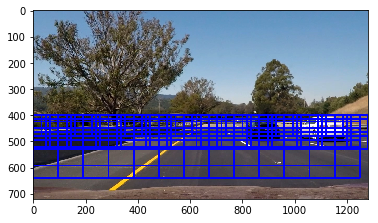

In [114]:
test_image_path = "../CarND-Vehicle-Detection/test_images/test6.jpg"
test_image = cv2.cvtColor(cv2.imread(test_image_path), cv2.COLOR_BGR2RGB)

windows_1 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[400, 484],xy_window=(64, 64), xy_overlap=(0.50, 0.750))
windows_2 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[416, 484],xy_window=(64, 64), xy_overlap=(0.50, 0.750))
windows_3 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[400, 528],xy_window=(96, 96), xy_overlap=(0.50, 0.750))
windows_4 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[432, 528],xy_window=(96, 96), xy_overlap=(0.50, 0.750))
windows_5 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[400, 550],xy_window=(128, 128), xy_overlap=(0.50, 0.750))
windows_6 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[432, 560],xy_window=(128, 128), xy_overlap=(0.50, 0.750))
windows_7 = slide_window(test_image, x_start_stop=[0,1280], y_start_stop=[400, 656],xy_window=(192, 192), xy_overlap=(0.50, 0.750))
#windows_8 = slide_window(test_image, x_start_stop=[0, 1280], y_start_stop=[464, 656], xy_window=(192, 192), xy_overlap=(0.50, 0.75))


windows = []
windows.extend(windows_1)
#windows.extend(windows_2)
windows.extend(windows_3)
#windows.extend(windows_4)
windows.extend(windows_5)
#windows.extend(windows_6)
windows.extend(windows_7)
#windows.extend(windows_8)

xx = draw_boxes(test_image, windows)
plt.imshow(xx)
cv2.imwrite("../CarND-Vehicle-Detection/output_images/search_area6.png", cv2.cvtColor(xx, cv2.COLOR_RGB2BGR))

True

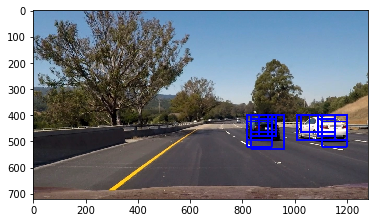

In [115]:
on_windows = search_windows(test_image, windows, features_scaler, svc)
xx = draw_boxes(test_image, on_windows)
plt.imshow(xx)
cv2.imwrite("../CarND-Vehicle-Detection/output_images/on_window6.png", cv2.cvtColor(xx, cv2.COLOR_RGB2BGR))

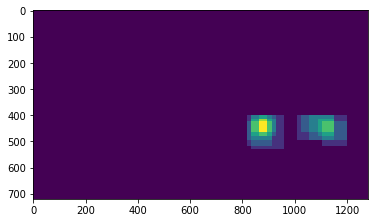

In [116]:
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
heat = add_heat(heat,on_windows)
plt.imshow(heat)
#cv2.imwrite("../CarND-Vehicle-Detection/output_images/heatmap1.png", cv2.cvtColor(heat, cv2.COLOR_BGR2RGB))

True

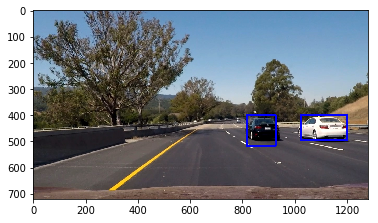

In [117]:
heat = apply_threshold(heat,1)

heatmap = np.clip(heat, 0, 255)
labels1 = label(heatmap)

draw_img = draw_labeled_bboxes(np.copy(test_image), labels1)

plt.imshow(draw_img)

cv2.imwrite("../CarND-Vehicle-Detection/output_images/final6.png", cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB))